<a href="https://colab.research.google.com/github/yonatan-co/skimlit/blob/main/12_milestone_project_skimlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# setup

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-3b537ea8-2e7e-61cf-6cfb-ad6d77d53699)


In [ ]:
!wget https://raw.githubusercontent.com/yonatan-co/t_helpers/main/helpers.py

--2022-10-17 12:56:42--  https://raw.githubusercontent.com/yonatan-co/t_helpers/main/helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11263 (11K) [text/plain]
Saving to: ‘helpers.py’

helpers.py          100%[===================>]  11.00K  --.-KB/s    in 0s      

2022-10-17 12:56:42 (103 MB/s) - ‘helpers.py’ saved [11263/11263]



In [ ]:
from helpers import  plot_history, create_tensorboard_callback, compare_historys, make_confusion_matrix

# data preprocessing

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [ ]:
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.
  
  Args:
      filename: a string containing the target filepath to read.
  
  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# load the data in lines

train_lines = get_lines('pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt')
val_lines = get_lines('pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt')
test_lines = get_lines('pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt')

In [ ]:
train_lines[1].split("\t")

['OBJECTIVE',
 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n']

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [ ]:
# prepare the data to modelig

%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 376 ms, sys: 82.2 ms, total: 458 ms
Wall time: 456 ms


(180040, 30212, 30135)

In [ ]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
import pandas as pd


train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


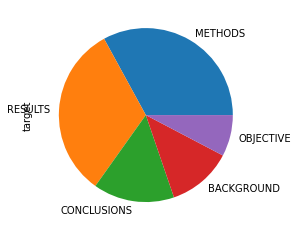

In [ ]:
train_df.target.value_counts().plot(kind="pie", title=None)

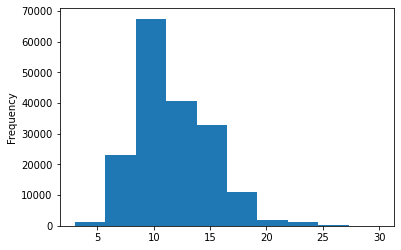

In [ ]:
train_df.total_lines.plot(kind="hist")

### label encode the data

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df["target"] = le.fit_transform(train_df['target'])
train_df.head()

,target,text,line_number,total_lines
0,3,to investigate the efficacy of @ weeks of dail...,0,11
1,2,a total of @ patients with primary knee oa wer...,1,11
2,2,outcome measures included pain reduction and i...,2,11
3,2,pain was assessed using the visual analog pain...,3,11
4,2,secondary outcome measures included the wester...,4,11


In [ ]:
val_df["target"] = le.fit_transform(val_df['target'])
val_df.head()

,target,text,line_number,total_lines
0,0,ige sensitization to aspergillus fumigatus and...,0,9
1,0,it is not clear whether these patients would b...,1,9
2,3,we sought to determine whether a @-month cours...,2,9
3,2,asthmatic patients who were ige sensitized to ...,3,9
4,2,primary outcomes were improvement in quality o...,4,9


In [ ]:
train_x = train_df["text"]
train_y = train_df["target"]

val_x = val_df["text"]
val_y = val_df["target"]

test_x = test_df["text"]
test_y = test_df["target"]

In [ ]:
num_classes = len(le.classes_)

# models expiraments

## model 0: naive bayes

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(train_x, train_y)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0_pred = model_0.predict(val_x)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def score_dict(y_true, y_pred):
  """
  gets true labels and predictions and return a dictiory include diffrent scoring method
  """
  accuracy = accuracy_score(y_true, y_pred) * 100
  precision_score, recall_score, f1_score, _  = precision_recall_fscore_support(y_true, y_pred, average='weighted') 
  score = {
      "accuracy": accuracy,
      "recall": recall_score,
      "precision": precision_score,
      "f1_score": f1_score
  }
  return score 

In [ ]:
model_0_scores = score_dict(val_y, model_0_pred)
model_0_scores

{'accuracy': 72.1832384482987,
 'recall': 0.7218323844829869,
 'precision': 0.7186466952323352,
 'f1_score': 0.6989250353450294}

## prepare data for deep models

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np


In [ ]:
sent_lens = [len(sent.split()) for sent in train_x]
sent_lens[:10]

[49, 27, 15, 14, 35, 29, 30, 55, 36, 8]

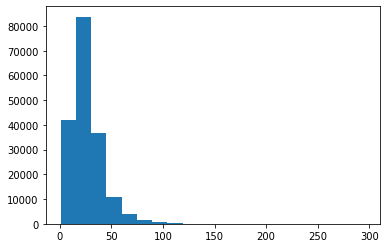

In [ ]:
import matplotlib.pyplot as plt

plt.hist(sent_lens, bins=20)
plt.show()

In [ ]:
# what length covers 95%
seq_length = int(np.percentile(sent_lens, 95))
seq_length

55

### text vectoraztion

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
max_words_in_vocab = 68000
max_seq_length = seq_length


text_vectorizer = TextVectorization(max_tokens=max_words_in_vocab,
                                    output_sequence_length=max_seq_length)



In [ ]:
# fit the vectorizer to the train data

text_vectorizer.adapt(train_x)

In [ ]:
# visuelize the vectoraztion

import random

random_sentence = random.choice(train_x)
print("the sentence before vectoraztion: \n", random_sentence)

print("-" * 400)

vectorized_sentence = text_vectorizer([random_sentence])
print("the sentence before vectoraztion: \n", vectorized_sentence)

the sentence before vectoraztion: 
 we conducted @ separate , multivariate , repeated-measures analyses of variance , followed by univariate analyses on any significant findings .
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
the sentence before vectoraztion: 
 tf.Tensor(
[[  43  198 2019 1012 3499  291    4 1581  284   22 3369  291   18  262
    37  310    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]], shape=(1, 55), dtype=int64)


In [ ]:
rct_20k_vocab = text_vectorizer.get_vocabulary()

print(f"words in vocab: {len(rct_20k_vocab)}")
print(f"\nthe most common words {rct_20k_vocab[:5]}")
print(f"\nthe least common words {rct_20k_vocab[-5:]}")

words in vocab: 64841

the most common words ['', '[UNK]', 'the', 'and', 'of']

the least common words ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


### emmbeding layer

In [ ]:
from tensorflow.keras.layers import Embedding


embedding = Embedding(input_dim=max_words_in_vocab,
                     output_dim=128,
                     mask_zero=True)




In [ ]:
random_sentence = random.choice(train_x)
print("the sentence before vectoraztion: \n", random_sentence)

print("-" * 400)

vectorized_sentence = embedding(text_vectorizer([random_sentence]))
print("the sentence before vectoraztion: \n", vectorized_sentence)

the sentence before vectoraztion: 
 compared with the control diet , the high-fructose diet significantly increased ihcls by @ @ % and hgp by @ @ % and decreased fasting lipid oxidation by @ @ % ( all p < @ ) .
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
the sentence before vectoraztion: 
 tf.Tensor(
[[[ 0.00830317 -0.02439971 -0.02771707 ... -0.02517301  0.0027064
    0.02839491]
  [-0.01046811 -0.01742133  0.02472513 ...  0.01918857  0.04412873
   -0.00853262]
  [ 0.00728816 -0.01991904  0.01884748 ... -0.01249875 -0.01578905
    0.02874157]
  ...
  [-0.02154191 -0.04758583  0.01821193 ... -0.02899451 -0.01154554
    0.02862072]
  [-

### create datasets

In [ ]:
import tensorflow as tf

train_words = tf.data.Dataset.from_tensor_slices((train_x, train_y))
val_words = tf.data.Dataset.from_tensor_slices((val_x, val_y))
test_words = tf.data.Dataset.from_tensor_slices((test_x, test_y))


In [ ]:
train_words = train_words.batch(32).prefetch(tf.data.AUTOTUNE)
val_words = val_words.batch(32).prefetch(tf.data.AUTOTUNE)
test_words = test_words.batch(32).prefetch(tf.data.AUTOTUNE)

## model 1: Conv 1D

In [ ]:
from tensorflow.keras import layers

input_ = layers.Input(shape=(1,), dtype=tf.string)
vectorized_text = text_vectorizer(input_)
embedded_text = embedding(vectorized_text)
x = layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(embedded_text)
x = layers.GlobalAveragePooling1D()(x)

output = layers.Dense(num_classes, activation="softmax")(x)


model_1 = tf.keras.Model(input_, output)


model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])



In [ ]:
model_1_history = model_1.fit(train_words,
                              steps_per_epoch=(0.1*len(train_words)),
                              epochs=3,
                              validation_data=val_words,
                              validation_steps=(0.1*len(val_words)))

Epoch 1/3
562/562 [==============================] - 14s 9ms/step - loss: 0.9136 - accuracy: 0.6380 - val_loss: 0.6858 - val_accuracy: 0.7408
Epoch 2/3
562/562 [==============================] - 4s 8ms/step - loss: 0.6549 - accuracy: 0.7564 - val_loss: 0.6323 - val_accuracy: 0.7684
Epoch 3/3
562/562 [==============================] - 4s 8ms/step - loss: 0.6152 - accuracy: 0.7733 - val_loss: 0.5964 - val_accuracy: 0.7855


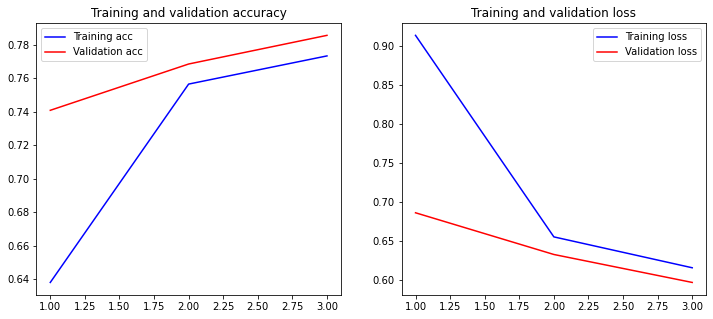

In [ ]:
plot_history(model_1_history)

In [ ]:
model_1_probs = model_1.predict(val_x)

945/945 [==============================] - 2s 2ms/step


In [ ]:
model_1_probs

array([[4.6507645e-01, 1.3995017e-01, 6.4884819e-02, 3.1079966e-01,
        1.9288955e-02],
       [4.7477818e-01, 2.2984077e-01, 1.4572935e-02, 2.7354148e-01,
        7.2666411e-03],
       [1.7015810e-01, 7.4322280e-03, 1.1191589e-03, 8.2125378e-01,
        3.6735815e-05],
       ...,
       [5.2283826e-06, 7.2300085e-04, 5.0764781e-04, 4.2583456e-06,
        9.9875987e-01],
       [6.0041036e-02, 3.7792563e-01, 1.6880877e-01, 8.0051705e-02,
        3.1317288e-01],
       [1.4802243e-01, 7.3704255e-01, 3.5352126e-02, 3.4287531e-02,
        4.5295291e-02]], dtype=float32)

In [ ]:
model_1_preds = tf.argmax(model_1_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_1_score = score_dict(val_y, model_1_preds)

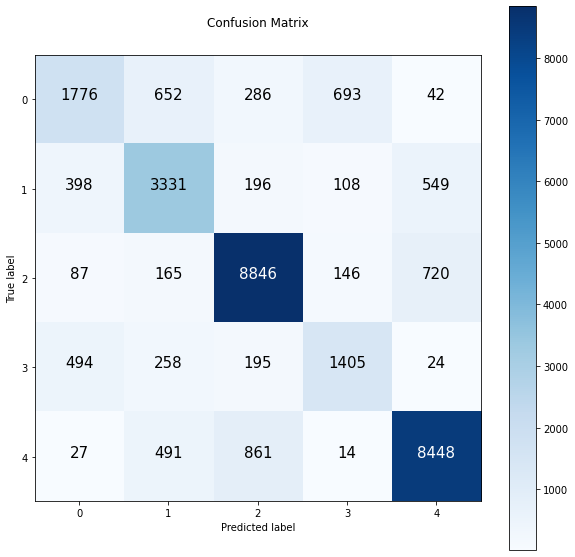

In [ ]:
make_confusion_matrix(val_y, model_1_preds)

## model 2: USE

In [ ]:
import tensorflow_hub as hub 



use_encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                              input_shape=[],
                              dtype=tf.string,
                              trainable=False,
                              name="USE")

In [ ]:

input_ = layers.Input(shape=[], dtype=tf.string, name="input_layer")
net = use_encoder(input_)
net = layers.Dense(128, activation="relu")(net)
output = layers.Dense(num_classes, activation='softmax', name="output_layer")(net)

model_2 = tf.keras.Model(input_, output)


model_2.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

In [ ]:
model_2_history = model_2.fit(train_words,
                              steps_per_epoch=(1*len(train_words)),
                              epochs=3,
                              validation_data=val_words,
                              validation_steps=(1*len(val_words)))

Epoch 1/3
5627/5627 [==============================] - 62s 10ms/step - loss: 0.7301 - accuracy: 0.7207 - val_loss: 0.6585 - val_accuracy: 0.7497
Epoch 2/3
5627/5627 [==============================] - 61s 11ms/step - loss: 0.6373 - accuracy: 0.7585 - val_loss: 0.6237 - val_accuracy: 0.7635
Epoch 3/3
5627/5627 [==============================] - 58s 10ms/step - loss: 0.6032 - accuracy: 0.7716 - val_loss: 0.6070 - val_accuracy: 0.7690


In [ ]:
model_2.evaluate(val_words)

945/945 [==============================] - 8s 9ms/step - loss: 0.6070 - accuracy: 0.7690


[0.6069690585136414, 0.7689659595489502]

In [ ]:
model_2_preds = model_2.predict(val_x)

945/945 [==============================] - 8s 8ms/step


In [ ]:
model_2_scores = score_dict(val_y, tf.argmax(model_2_preds, axis=1))

In [ ]:
model_2_scores

{'accuracy': 76.89659737852509,
 'recall': 0.7689659737852509,
 'precision': 0.7661417897990495,
 'f1_score': 0.7647467035960618}

In [ ]:
tf.argmax(model_2_preds, axis=1)

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 0, ..., 4, 4, 1])>

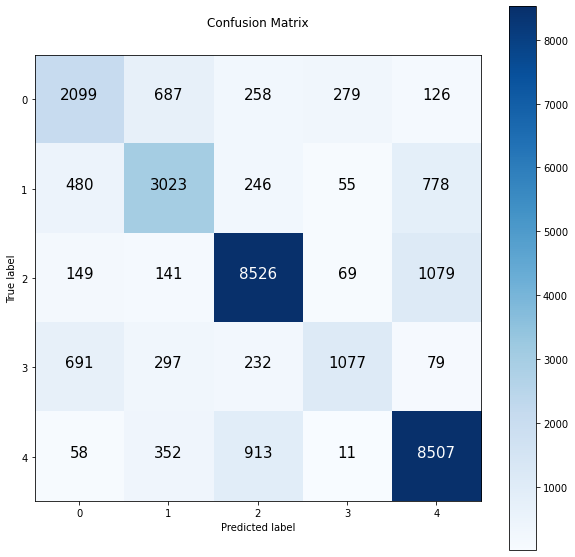

In [ ]:
make_confusion_matrix(val_y, tf.argmax(model_2_preds, axis=1))

## charcter-level data

### charcter-level vectoraztion

In [ ]:
def split_chars(text):
  return " ".join(list(text))

In [ ]:
split_chars(random_sentence)

'c o m p a r e d   w i t h   t h e   c o n t r o l   d i e t   ,   t h e   h i g h - f r u c t o s e   d i e t   s i g n i f i c a n t l y   i n c r e a s e d   i h c l s   b y   @   @   %   a n d   h g p   b y   @   @   %   a n d   d e c r e a s e d   f a s t i n g   l i p i d   o x i d a t i o n   b y   @   @   %   (   a l l   p   <   @   )   .'

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_x]
val_chars = [split_chars(sentence) for sentence in val_x]
test_chars = [split_chars(sentence) for sentence in test_x]

In [ ]:
# calculating the mean number of chars in a sentence

char_lens = [len(sentence) for sentence in train_x]
char_lens_mean = np.mean(char_lens)
char_lens_mean

149.3662574983337

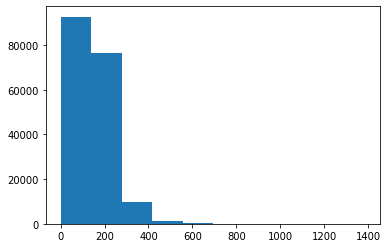

In [ ]:
import matplotlib.pyplot as plt

plt.hist(char_lens)
plt.show()

In [ ]:
# what char length covers 95% of the sentences?

output_seq_char = int(np.percentile(char_lens, 95))

# 290 it is.

In [ ]:
# get the whole alphabet

import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
max_char_tokens = len(alphabet) + 2 # for " " and [UNK]


char_vectorizer = TextVectorization(max_tokens=max_char_tokens,
                                    output_sequence_length=output_seq_char,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")


char_vectorizer.adapt(train_chars)


In [ ]:
char_vocab = char_vectorizer.get_vocabulary()

In [ ]:
print(f"words in vocab: {len(char_vocab)}")
print(f"\nthe most common words {char_vocab[:5]}")
print(f"\nthe least common words {char_vocab[-5:]}")

words in vocab: 28

the most common words ['', '[UNK]', 'e', 't', 'i']

the least common words ['k', 'x', 'z', 'q', 'j']


In [ ]:
import random

random_chars = random.choice(train_chars)
print("the sentence before vectoraztion: \n", random_sentence)
print(f"the length of the char sequence {len(random_chars.split())}")

print("-" * 400)

vectorized_sentence = char_vectorizer([random_chars])
print("the sentence before vectoraztion: \n", vectorized_sentence)

the sentence before vectoraztion: 
 compared with the control diet , the high-fructose diet significantly increased ihcls by @ @ % and hgp by @ @ % and decreased fasting lipid oxidation by @ @ % ( all p < @ ) .
the length of the char sequence 193
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
the sentence before vectoraztion: 
 tf.Tensor(
[[14  8  7 14 13 19 12  5 11  3  4 11  3  8  2  5  3 15  2  6  3 15  5 19
  22  2 11  7  6  9  4 10  2  8  2 10  5  9  5  6  7 14  3  4  7  6  3  7
  15  4  6  4 15  4  9  2  6  2 16  8  7  8  2  3  4  6  5 12  8  4 15 10
   5 15  5 18  2  4  6 13  4 18 13  8  4  9 23 18 12  5 16 11  7 15  5 14
   5  3  

### charcter-level embedding

In [ ]:
NUM_CHAR_TOKENS = len(alphabet)

char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
p r o p h y l a c t i c   t r e a t m e n t   m a y   b e   c o n s i d e r e d   a s   a n   o p t i o n   t o   m i n i m i s e   n e u r o - r e t i n a l   r i m   d a m a g e   i n   h i g h - r i s k   g l a u c o m a   p a t i e n t s   w h o   a r e   m o s t   v u l n e r a b l e   t o   i o p   s p i k e s   a n d   u n d e r g o i n g   r e p e a t e d   i n t r a v i t r e a l   i n j e c t i o n s   o f   r a n i b i z u m a b   .

Embedded chars (after vectorization and embedding):
[[[ 0.03318225 -0.00973064 -0.02934483 ... -0.01991172  0.03664832
   -0.00143116]
  [-0.01510649 -0.00576141 -0.01517407 ...  0.04784809  0.04230616
    0.00324963]
  [ 0.0116186   0.03114596  0.02544001 ...  0.02722934  0.01059204
   -0.0075992 ]
  ...
  [-0.02343925 -0.01569735 -0.04677515 ... -0.00480456 -0.01674511
   -0.03849722]
  [-0.02343925 -0.01569735 -0.04677515 ... -0.00480456 -0.01674511
   -0.03849722]
  [-0.02343925 -0.0156973

### charcter-level data sets

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_y)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_y)).batch(32).prefetch(tf.data.AUTOTUNE)


## model 3: Conv 1D with charcter embedding

In [ ]:
from tensorflow.keras import layers


input_ = layers.Input(shape=(1,), dtype=tf.string, name="input_layer")
vectorized_input = char_vectorizer(input_)
embedded_input = embedding(vectorized_input)

x = layers.Conv1D(filters=64, kernel_size=5, activation="relu", padding="same")(embedded_input)
x = layers.GlobalMaxPooling1D()(x)

output = layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

model_3 = tf.keras.Model(input_, output)


# compile the model
model_3.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

In [ ]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=(0.1 * len(val_char_dataset)))

NameError: ignored

## create a multi-input dataset

In [ ]:
# training dataset

train_char_token_data = tf.data.Dataset.from_tensor_slices((train_x, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_y)
train_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# validation dataset

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_x, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_y)
val_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset, val_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## model 4: multi-input model (bi-LSTM & USE encoder)

In [ ]:
import tensorflow_hub as hub 

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                              input_shape=[],
                              dtype=tf.string,
                              trainable=False,
                              name="USE")

In [ ]:
from tensorflow.keras import layers


token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [ ]:
model_4.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   [

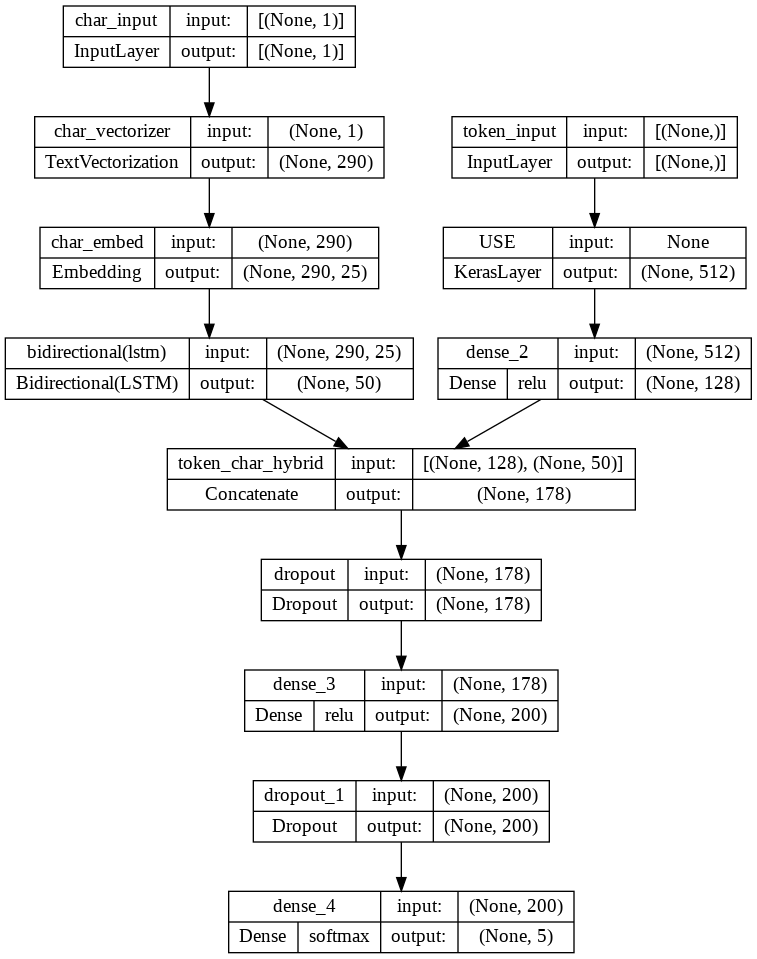

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True, show_layer_activations=True)

In [ ]:
model_4_history = model_4.fit(train_dataset,
                              steps_per_epoch=(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 23s 30ms/step - loss: 0.9693 - accuracy: 0.6173 - val_loss: 0.7991 - val_accuracy: 0.6888
Epoch 2/3
562/562 [==============================] - 19s 33ms/step - loss: 0.7982 - accuracy: 0.6895 - val_loss: 0.7219 - val_accuracy: 0.7257
Epoch 3/3
562/562 [==============================] - 17s 31ms/step - loss: 0.7703 - accuracy: 0.7048 - val_loss: 0.6980 - val_accuracy: 0.7339


In [ ]:
model_4_probs = model_4.predict(val_dataset)


945/945 [==============================] - 17s 17ms/step


In [ ]:
model_4_preds = tf.argmax(model_4_probs, axis=1)


In [ ]:
score_dict(val_y, model_4_preds)

{'accuracy': 73.25896994571693,
 'recall': 0.7325896994571693,
 'precision': 0.7358128019109209,
 'f1_score': 0.7306477449224387}

## feature enginering the line numbers (& the total lines number)




#### one-hot encode the line number feature

In [ ]:
train_df.line_number.value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

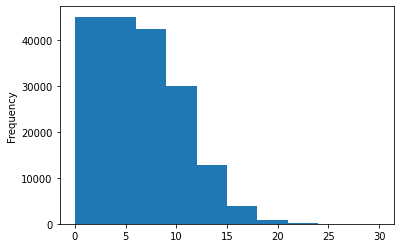

In [ ]:
train_df.line_number.plot(kind="hist")

In [ ]:
train_line_number = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_number = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_number = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

train_line_number, val_line_number, test_line_number

(<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(30212, 15), dtype=float32, numpy=
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(30135, 15), dtype=float32, numpy=
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>)

#### one-hot encode the total lines number feature

In [ ]:
train_df.total_lines.value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

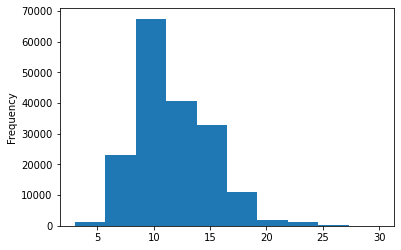

In [ ]:
train_df.total_lines.plot(kind="hist")

In [ ]:
train_total_lines = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

train_total_lines, val_total_lines, test_total_lines

(<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(30212, 20), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(30135, 20), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)>)

## model 5: 4 inputs model (token level embedding, char level embedding, line number & total lines)

In [130]:
from tensorflow.keras import layers

# input 1
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# input 2 
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) 
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# input 3
line_num_input = layers.Input(shape=(15), name="line_num_input")
line_num_output = layers.Dense(32, activation="relu")(line_num_input)
line_num_model = tf.keras.Model(inputs=line_num_input,
                                outputs=line_num_output)

# input 4
total_lines_input = layers.Input(shape=(20), name="total_lines_input")
total_lines_output = layers.Dense(32, activation="relu")(total_lines_input)
total_lines_model = tf.keras.Model(inputs=total_lines_input,
                                   outputs=total_lines_output)

token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

x = layers.Dense(256, activation="relu")(token_char_concat)
x = layers.Dropout(0.5)(x)

total_concat = layers.Concatenate(name="concatenate_layer")([x,
                                                             line_num_model.output,
                                                             total_lines_model.output])


output_layer = layers.Dense(num_classes, activation="softmax")(total_concat)



model_5 = tf.keras.Model(inputs=[token_model.input, char_model.input, line_num_model.input, total_lines_model.input],
                         outputs=output_layer,
                         name="model_5_tribird")

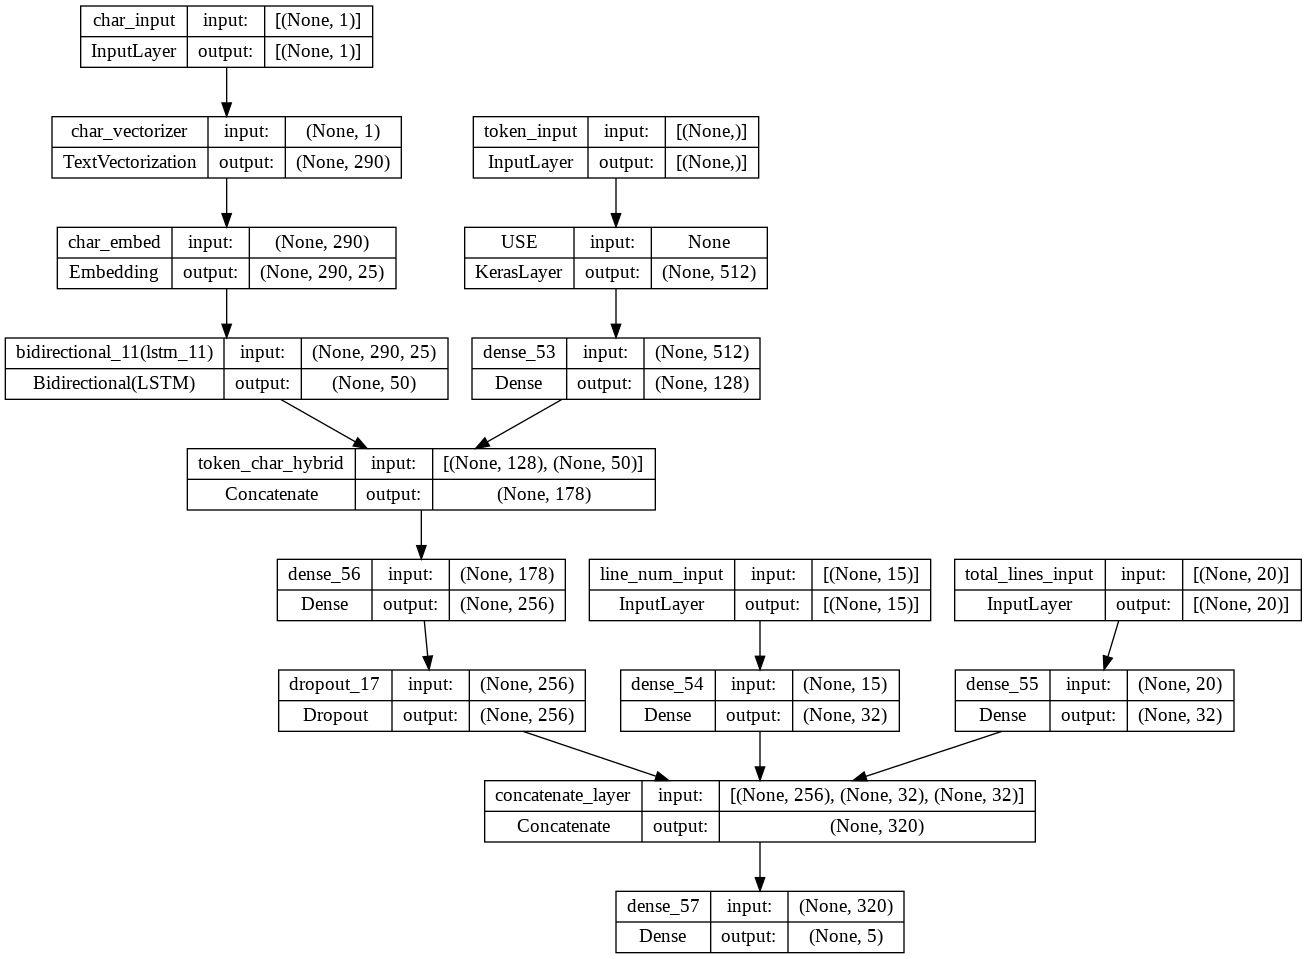

In [131]:
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [132]:
model_5.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### creating multi-level data input pipe lines

In [129]:
# training dataset

train_char_token_data = tf.data.Dataset.from_tensor_slices((train_x,
                                                            train_chars,
                                                            train_line_number,
                                                            train_total_lines))

train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_y)

train_dataset = tf.data.Dataset.zip((train_char_token_data,
                                     train_char_token_labels))

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# validation data set 

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_x,
                                                          val_chars,
                                                          val_line_number,
                                                          val_total_lines))


val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_y)

val_dataset = tf.data.Dataset.zip((val_char_token_data,
                                   val_char_token_labels))

val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### fit model 5

In [133]:
model_5_history = model_5.fit(train_dataset,
                              steps_per_epoch=len(train_dataset),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=len(val_dataset))

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5627/5627 [==============================] - 167s 29ms/step - loss: 0.4659 - accuracy: 0.8240 - val_loss: 0.3787 - val_accuracy: 0.8532
Epoch 2/3
5627/5627 [==============================] - 161s 29ms/step - loss: 0.3695 - accuracy: 0.8607 - val_loss: 0.3576 - val_accuracy: 0.8625
Epoch 3/3
5627/5627 [==============================] - 161s 29ms/step - loss: 0.3417 - accuracy: 0.8717 - val_loss: 0.3513 - val_accuracy: 0.8671


In [ ]:
model_5.evaluate(val_dataset)

945/945 [==============================] - 19s 21ms/step - loss: 0.4399 - accuracy: 0.8293


[0.43991610407829285, 0.8293062448501587]

In [ ]:
model_5_probs = model_5.predict(val_dataset)

945/945 [==============================] - 17s 17ms/step


In [ ]:
model_5_preds = tf.argmax(model_5_probs, axis=1)

In [ ]:
score_dict(val_y, model_5_preds)

{'accuracy': 82.9306235932742,
 'recall': 0.829306235932742,
 'precision': 0.8289281259343102,
 'f1_score': 0.8289257023245867}

In [134]:
model_5.save("/content/drive/MyDrive/tensorflow models/skimlit")